In [33]:
import os
import time
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import networkx as nx

from scipy.spatial import KDTree

import src
from src.reload import deep_reload

In [255]:
#Fake data - n points in an m by m area, d - max distance for primary edges
n=50
m=200e3 #[m]
d=50e3

x,y=np.random.rand(2,n)*m

xg0,xg1=np.meshgrid(x,x)
yg0,yg1=np.meshgrid(y,y)

adj=np.sqrt((xg1-xg0)**2+(yg1-yg0)**2)
adj[adj>d]=0

In [256]:
#Assigning chargers to nodes
chargers=np.random.randint(0,2,size=len(adj),dtype=bool)

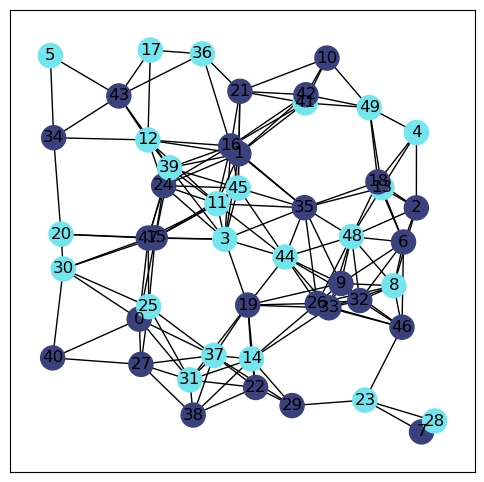

In [257]:
#Plotting
fig,ax=plt.subplots(figsize=(6,6))

color_scheme=["#72e5ef", "#3a427d"]
colors=np.empty(n,dtype=object)
colors[~chargers]=color_scheme[0]
colors[chargers]=color_scheme[1]

nxg=nx.from_numpy_array(adj)

nx.set_node_attributes(nxg,chargers,'charger')
nx.draw_networkx(nxg,ax=ax,pos=np.vstack((x,y)).T,node_color=colors)

In [258]:
'''
Most basic form of dijkstra routing
Computes shortest path from any one vertex to all others
In this case a random vertex is picked
outouts are shortest paths and weights of shortest paths (dicts)
'''
deep_reload(src)

start_vertex=np.random.randint(0,n-1)

shortest_paths,shortest_path_weights=src.dijkstra.Dijkstra(start_vertex,adj)

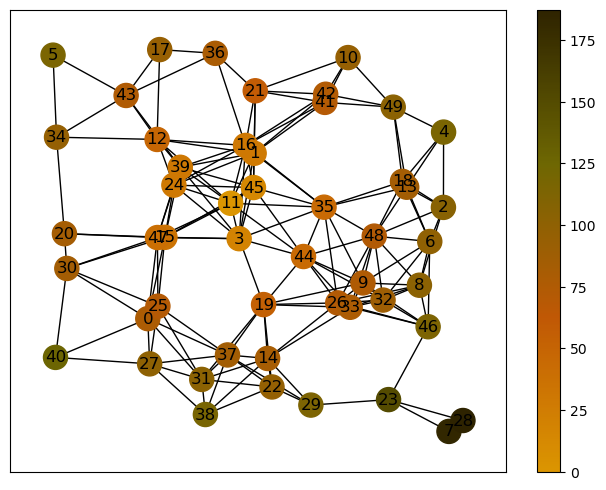

In [259]:
#Plotting

fig,ax=plt.subplots(figsize=(8,6))

color_scheme=["#db9501","#c05805","#6e6702","#2e2300"]
cmap=LinearSegmentedColormap.from_list('custom',color_scheme,N=256)

distances=np.array([value for key,value in shortest_path_weights.items()])
colors=cmap(distances/distances.max())

nxg=nx.from_numpy_array(adj)

nx.set_node_attributes(nxg,chargers,'charger')
nx.draw_networkx(nxg,ax=ax,pos=np.vstack((x,y)).T,node_color=colors)
sm=plt.cm.ScalarMappable(cmap=cmap,
                         norm=plt.Normalize(vmin=distances.min()/1e3,
                                            vmax=distances.max()/1e3))
plt.colorbar(sm,ax=ax)

In [260]:
'''
Vehicle routing with charging
Computes shortest FEASIBLE path from any one vertex to all others
Only paths where sufficient charging is available are allowed
In this case a random vertex is picked
outouts are shortest paths, weights of shortest paths,
and projected remaining range at arrival(dicts)
'''
deep_reload(src)

start_vertex=np.random.randint(0,n-1)
vehicle_range=150e3

shortest_paths,shortest_path_weights,remaining_range=src.dijkstra.Dijkstra_Range(
    start_vertex,adj,vehicle_range=vehicle_range,extension=chargers)

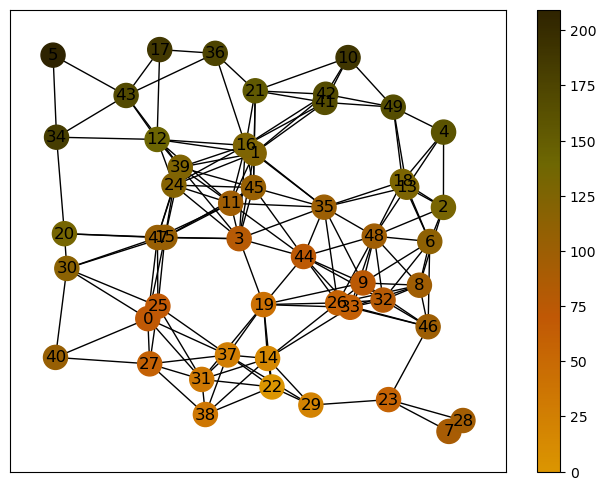

In [261]:
#Plotting

fig,ax=plt.subplots(figsize=(8,6))

color_scheme=["#db9501","#c05805","#6e6702","#2e2300"]
cmap=LinearSegmentedColormap.from_list('custom',color_scheme,N=256)

distances=np.array([value for key,value in shortest_path_weights.items()])
colors=cmap(distances/distances.max())

nxg=nx.from_numpy_array(adj)

nx.set_node_attributes(nxg,chargers,'charger')
nx.draw_networkx(nxg,ax=ax,pos=np.vstack((x,y)).T,node_color=colors)
sm=plt.cm.ScalarMappable(cmap=cmap,
                         norm=plt.Normalize(vmin=distances.min()/1e3,
                                            vmax=distances.max()/1e3))
plt.colorbar(sm,ax=ax)

Note that not all points are necessarily reachable and that those that are may require less efficient paths and thus the scale should be different than the above plot - this is due to the low range and the uneven distribution of chargers

In [242]:
'''
Simple Dijkstra with Numba njit cashed compilation
'''
deep_reload(src)

start_vertex=np.random.randint(0,n-1)

shortest_paths,shortest_path_weights=src.dijkstra.Dijkstra_NJIT(start_vertex,adj)

In [247]:
'''
Ranged Dijkstra with Numba njit cashed compilation
'''
deep_reload(src)

start_vertex=np.random.randint(0,n-1)
vehicle_range=150e3

shortest_paths,shortest_path_weights,remaining_range=src.dijkstra.Dijkstra_Range_NJIT(
    start_vertex,adj,vehicle_range=vehicle_range,extension=chargers)

Runtime comparison between non-compiled and compiled:

In [234]:
%timeit sp,spw=src.dijkstra.Dijkstra(0,adj)

324 µs ± 6.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [235]:
%timeit sp,spw=src.dijkstra.Dijkstra_NJIT(0,adj)

72.5 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [262]:
'''
Now for the Vehicle Routing Problem (VRP) using Clarke and Wright's Savings Heuristic
[http://dx.doi.org/10.1287/opre.12.4.568]

The VRP can be solved in many ways including as a linear problem, here is a fast heuristic
'''
deep_reload(src)

#First computing shortest path information for all pairs
(ap_shortest_paths,
ap_shortest_path_weights,
ap_remaining_range)=src.dijkstra.All_Pairs_Shortest_Paths(adj,chargers,vehicle_range)

In [333]:
#Generating random data for the Savings Heuristic
deep_reload(src)


delivery_vertices=np.random.randint(0,n-1,size=11)
depot_vertex=delivery_vertices[0]
delivery_vertices=delivery_vertices[1:]
adj_sel=src.savings.AdjacencyFromPathWeights(ap_shortest_path_weights,
                                     [depot_vertex,*delivery_vertices])
delivery_loads=np.random.rand(10)*5
vehicle_capacity=10
vehicle_range=500e3

#Calling the Savings method
routes,route_loads,route_distances,success=src.savings.Savings(adj_sel,
                                depot_vertex,
                                delivery_vertices,
                                delivery_loads,
                                vehicle_capacity,
                                vehicle_range)

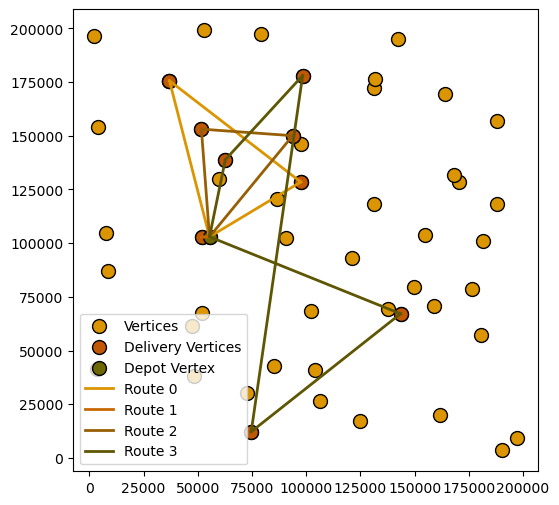

In [342]:
#Plotting
fig,ax=plt.subplots(figsize=(6,6))

color_scheme=["#72e5ef", "#1c5b5a", "#2da0a1"]
color_scheme=["#db9501","#c05805","#6e6702","#2e2300"]

cmap=LinearSegmentedColormap.from_list('custom',color_scheme,N=256)
# color_scheme=["#e6df44","#f0810f","#063852","#011a27"]

pos=np.vstack((x,y)).T

s=100
ax.scatter(pos[:,0],pos[:,1],s=s,c=color_scheme[0],ec='k',label='Vertices')
ax.scatter(pos[delivery_vertices,0],pos[delivery_vertices,1],
           s=s,c=color_scheme[1],ec='k',label='Delivery Vertices')
ax.scatter(pos[depot_vertex,0],pos[depot_vertex,1],s=s,c=color_scheme[2],ec='k',
          label='Depot Vertex')

for idx0,route in enumerate(routes):
    from_indices=route[:-1]
    to_indices=route[1:]

    for idx1 in range(len(from_indices)):
        label=''
        if idx1==0:
            label=f'Route {idx0}'

        ax.plot([pos[from_indices[idx1],0],pos[to_indices[idx1],0]],
                   [pos[from_indices[idx1],1],pos[to_indices[idx1],1]],lw=2,
                    color=cmap(idx0/len(routes)-.001),label=label)
ax.legend()